<a href="https://colab.research.google.com/github/JS-Abhishek/Spatial-Attention-Network-for-DR-Classification/blob/main/VGG_16_Attention_Gaussian_Blur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!nvidia-smi

Sun May 30 05:17:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import random 
from numpy.random import seed
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Permute, Lambda, Conv2D, multiply, Concatenate, concatenate, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os, time
import tensorflow as tf
import math
from keras.callbacks import LearningRateScheduler
from keras import optimizers

In [ ]:
def spatial_attention(input_feature):
  kernel_size = 7
  if K.image_data_format() == "channels_first":
    channel = input_feature.shape[1]
    cbam_feature = Permute((2,3,1))(input_feature)
  else:
    channel = input_feature.shape[-1]
    cbam_feature = input_feature
  
  avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
  assert avg_pool.shape[-1] == 1
  max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
  assert max_pool.shape[-1] == 1
  concat = Concatenate(axis=3)([avg_pool, max_pool])
  assert concat.shape[-1] == 2
  cbam_feature = Conv2D(filters = 1,
                        kernel_size = kernel_size,
                        strides = 1,
                        padding='same',
                        activation = 'sigmoid',
                        kernel_initializer='he_normal',
                        use_bias=False)(concat)
  assert cbam_feature.shape[-1] == 1

  if K.image_data_format() == "channels_first":
    cbam_feature = Permute((3,1,2))(cbam_feature)
  x1 = concatenate([input_feature, cbam_feature])
  return x1

In [ ]:
train_dir = '/content/gdrive/MyDrive/Training/JS/train_1/'
test_dir = '/content/gdrive/MyDrive/Training/JS/test_1/'

In [ ]:
IMAGE_SIZE = (256,256)
NUM_CLASSES = len(os.listdir(train_dir))
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001

In [ ]:
def step_decay(epoch):
  initial_lrate = 0.0001
  drop = 0.4
  epochs_drop = 4.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 50,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.25,
                                   zoom_range = 0.1,
                                   channel_shift_range = 20,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split=0.2,
                                   fill_mode='constant')

In [ ]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = BATCH_SIZE,
    subset = "training",
    seed = 42,
    class_mode = "categorical"
    )

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = BATCH_SIZE,
    subset = "validation",
    seed = 42,
    class_mode = "categorical"
)

Found 11768 images belonging to 5 classes.
Found 2940 images belonging to 5 classes.


In [ ]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (256, 256, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
layer_names = [layer.name for layer in conv_base.layers]

In [ ]:
conv_base.get_layer('block4_pool').output

<KerasTensor: shape=(None, 16, 16, 512) dtype=float32 (created by layer 'block4_pool')>

In [ ]:
conv_base = Model(inputs=conv_base.inputs, outputs=conv_base.get_layer('block4_pool').output)

In [ ]:
def fine_tune(conv_base):
  for layers in conv_base.layers:
    layers.trainable = True
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(NUM_CLASSES, activation='softmax'))
  print(model.summary())
  return model

In [ ]:
def Trunc_VGG(conv_base):
  conv_base.trainable = True
  layer_4th = conv_base.get_layer('block4_pool').output
  attention_module = spatial_attention(layer_4th)
  print(attention_module.shape)
  flatten = Flatten()(attention_module)
  dropout = Dropout(0.5)(flatten)
  dense = Dense(256, activation='relu')(dropout)
  pred = (Dense(NUM_CLASSES, activation='softmax'))(dense)
  model = Model(inputs = conv_base.inputs, outputs = pred)
  return model


In [ ]:
#train_s_time = time.clock()
model = Trunc_VGG(conv_base)

STEP_SIZE_TRAIN = train_batches.n//train_batches.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

(None, 16, 16, 513)


In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = optimizers.Adam(lr = LEARNING_RATE),
              metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

result = model.fit_generator(train_batches,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = val_generator,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = NUM_EPOCHS,
                             callbacks = callbacks_list
                             )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
367/367 [==============================] - 5530s 15s/step - loss: 1.8894 - acc: 0.2556 - val_loss: 1.1962 - val_acc: 0.4955
Epoch 2/20
367/367 [==============================] - 288s 785ms/step - loss: 1.1841 - acc: 0.4888 - val_loss: 1.0897 - val_acc: 0.5388
Epoch 3/20
367/367 [==============================] - 287s 781ms/step - loss: 1.0133 - acc: 0.5607 - val_loss: 1.0060 - val_acc: 0.5951
Epoch 4/20
367/367 [==============================] - 285s 776ms/step - loss: 0.8561 - acc: 0.6426 - val_loss: 0.8497 - val_acc: 0.6590
Epoch 5/20
367/367 [==============================] - 286s 778ms/step - loss: 0.7808 - acc: 0.6746 - val_loss: 0.7265 - val_acc: 0.6947
Epoch 6/20
367/367 [==============================] - 284s 775ms/step - loss: 0.7270 - acc: 0.7000 - val_loss: 0.6256 - val_acc: 0.7541
Epoch 7/20
367/367 [==============================] - 284s 774ms/step - loss: 0.6502 - acc: 0.7364 - val_loss: 0.7373 - val_acc: 0.7050
Epoch 8/20
367/367 [=============================

In [ ]:
model.save('VGG-16-DR_Gaussian_iter1.h5')

In [ ]:
model.save_weights('VGG-16_DR_Gaussian_Weights_iter1.h5')

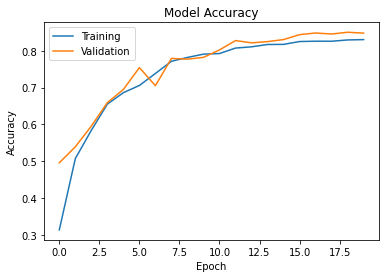

In [ ]:
import matplotlib.pyplot as plt
fig1 = plt.figure(1)
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
#plt.savefig(root_path + '/' + 'acc.png')
plt.show()

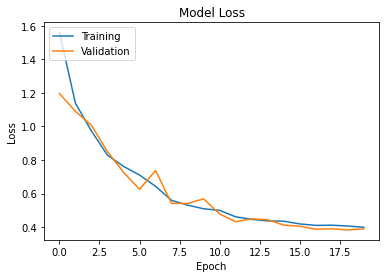

In [ ]:
fig2 = plt.figure(2)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
#plt.savefig(root_path + '/' + 'loss.png')
plt.show()
